In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import sys
import numpy as np
import yaml
from typing import Dict
from tqdm import tqdm

from adase.utils.pandas import read_df
from adase.utils.files import (directory_path,
                                get_raw_file,
                                get_all_files)
from adase.utils.pandas import write_df, read_df

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def config(path) -> Dict:
    with open("{}config.yml".format(path), 'r') as ymlfile:
            cfg = yaml.load(ymlfile)
    return cfg

def download_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    for file in tqdm(cfg.get('makedataset').get('files')):
        get_raw_file(raw_path, file)

def load_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    
    dict_data: Dict = dict()

    for key, val in read_df(get_all_files(raw_path)).items():

        df_tmp = val.rename(columns={
                    'item': 'item_code',
                    'quantity_ecd': 'quantity',
                    'parent_item': 'parent_item_code',
                    'parent_quantity_ecd': 'parent_quantity'
                })

        if 'rpd' in df_tmp:
            first_element = sorted(df_tmp['rpd'].unique())[0]
            if first_element/1 != 1:
                df_tmp['rpd'] = df_tmp['rpd'] - (first_element-1)

        dict_data.update({key: df_tmp})
                
    return dict_data

cfg = config('../')
download_dataset(cfg)
data_dicts = load_dataset(cfg)

100%|██████████| 9/9 [00:00<00:00, 108.29it/s]


In [3]:
data_series = data_dicts.get('demand_out_encoded_stage_3')\
.set_index(['item_code', 'rpd','future_flag'])\
.sort_index().unstack("rpd", fill_value=0).fillna(0).values

mu, sigma = 0, 0.1 
#[:600]
#data = np.log1p(
data = np.log1p(data_series[:]) + np.abs(np.random.normal(mu, sigma, size=data_series.shape))

In [4]:
np.random.seed(1)

T = 40
L = 44 # length of time-series
N = data.shape[0] # dataset size

#x = np.empty((N, L), 'int64')
#x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
#data = np.sin((x.T / ((np.random.rand(N)**2)*T + 1)).T).astype('float64')

In [5]:
data

array([[4.12841345e-02, 6.03049640e+00, 7.61954850e+00, ...,
        6.40960464e+00, 7.96712724e+00, 4.64806177e-02],
       [5.02693821e-02, 6.01000961e+00, 7.63079075e+00, ...,
        6.13495107e+00, 7.71543374e+00, 8.47683963e-03],
       [1.24730368e-01, 2.77050841e-03, 3.73125044e-02, ...,
        1.76236817e-01, 7.84753147e+00, 6.83912856e-02],
       ...,
       [9.88822771e+00, 8.99092517e-02, 4.42262793e-03, ...,
        7.13825620e+00, 9.90442773e+00, 9.68673522e+00],
       [2.34516198e-02, 1.22640285e-01, 8.70985747e-02, ...,
        7.35782977e-02, 8.88378340e+00, 9.84978659e-02],
       [2.77631368e-02, 1.73682987e-02, 2.33776171e-03, ...,
        3.09240555e-02, 8.90827868e+00, 7.56984636e-02]])

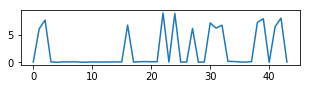

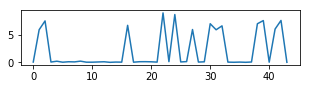

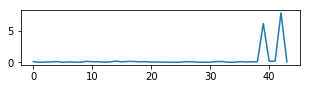

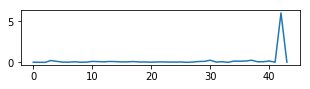

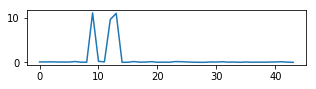

In [6]:
# here we plot some generated time-series
for i in range(5):
    plt.figure(figsize=(5, 1))
    plt.plot(data[i])

In [7]:
device = torch.device("cpu")
batch_size = 64
log_interval = N/600
data_tensor = torch.stack([torch.Tensor(x) for x in data])

In [8]:
data_tensor.shape

torch.Size([2646, 44])

In [9]:
ts_dataset_train = torch.utils.data.TensorDataset(data_tensor[:int(N*5/6)])
ts_dataset_test = torch.utils.data.TensorDataset(data_tensor[int(N*5/6):])

train_loader = torch.utils.data.DataLoader(ts_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ts_dataset_test, batch_size=batch_size, shuffle=True)

In [10]:
# VAE model

class VAE(nn.Module):
    def __init__(self, K=12, P=5, mp=3, hidden_lsz=2, channels=10, lstm_sz=10):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=channels, kernel_size=K, padding=P)
        self.mp1 = nn.MaxPool1d(kernel_size=mp, stride=mp, return_indices=True)
        conv_sz = self.conv1.out_channels * ((L + 1 - (K - 2*P)) // mp)
        self.fc21 = nn.Linear(conv_sz, hidden_lsz)
        self.fc22 = nn.Linear(conv_sz, hidden_lsz)
        self.fc3 = nn.Linear(hidden_lsz, conv_sz)
        self.ump4 = nn.MaxUnpool1d(kernel_size=mp, stride=mp)
        self.deconv4 = nn.ConvTranspose1d(in_channels=channels, out_channels=1, kernel_size=K, padding=P)
        self.polish = nn.LSTM(1, lstm_sz, num_layers=1)
        self.fc4 = nn.Linear(lstm_sz, 1)

    def encode(self, x):
        h1, self.mp1_inds = self.mp1(F.relu(self.conv1(x.unsqueeze(1))))
        h1 = h1.view(h1.shape[0], -1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) #+ 1e-5
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.ump4(F.relu(self.fc3(z).unsqueeze(1).view(z.shape[0], self.deconv4.in_channels, -1)),
                       self.mp1_inds)
        h4 = F.relu(self.deconv4(h3))
        h4 = h4.transpose(1, 0).transpose(2, 0)
        h5, _ = self.polish(h4)
        h5 = F.relu(h5)
        return self.fc4(h5).transpose(1, 0).squeeze()

    def forward(self, x, variational_sample=1):
        #print(x.shape)
        mu, logvar = self.encode(x.view(-1, L))
        #print('mu: {}'.format(mu))
        #print('logvar: {}'.format(logvar))
        for i in range(variational_sample):
            z = self.reparameterize(mu, logvar)
            recon_x = self.decode(z)
            if i == 0:
                reconstruction = torch.zeros_like(recon_x)
            reconstruction += recon_x
        reconstruction /= variational_sample
        #print('reconstruction: {}'.format(reconstruction))
        return reconstruction, mu, logvar

In [11]:
def loss_component_KLD(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return KLD

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x.view(-1, x.shape[1]))

    return MSE + loss_component_KLD(mu, logvar)

def train(epoch, max_batches=2):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        #print('data[0].to(device): {}'.format(data))
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        #print('recon_batch: {}'.format(recon_batch))
        #print('data: {}'.format(data[:, :recon_batch.shape[1]]))
        loss = loss_function(recon_batch, data[:, :recon_batch.shape[1]], mu, logvar)
        loss.backward()
        #print('loss: {}'.format(loss))
        #sys.exit(0)
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if batch_idx / log_interval >= max_batches:
                break
    
    train_loss /= ((batch_idx + 1)*batch_size)
    return train_loss

def save_ts_image_overlap(ts_tensor_1, ts_tensor_2, file_path, nrow=1, h=1, w=3, off_axis=False):
    ncol = int(np.ceil(len(ts_tensor_1)/float(nrow)))
    plt.figure(figsize=(w*nrow, h*ncol))
    for i in range(len(ts_tensor_1)):
        plt.subplot(ncol, nrow, i + 1)
        plt.plot(ts_tensor_1[i].data.numpy())
        plt.plot(ts_tensor_2[i].data.numpy())
        if off_axis:
            plt.xticks([])
            plt.yticks([])
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', dpi=100)
    plt.close()

def test(epoch, output_path, recon_samples=1):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader): 
            data = data[0].to(device)
            
            for r in range(recon_samples):
                recon_batch_part, mu, logvar = model(data)
                if r == 0:
                    recon_batch = recon_batch_part
                else:
                    recon_batch += recon_batch_part
            recon_batch /= recon_samples
            
            test_loss += loss_function(recon_batch, data[:, :recon_batch.shape[1]], mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n, :recon_batch.shape[1]],
                                      recon_batch[:n]])
                save_ts_image_overlap(data[:n, :recon_batch.shape[1]], 
                                      recon_batch[:n],
                                      output_path + str(epoch) + '.png', 
                                      nrow=n)
                
                #plot_tsne(mu, None, 'VAE')
                
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, mu

In [12]:
latent_dim = 5
output_path = '../output/'
model = VAE(K=36, P=17, hidden_lsz=latent_dim, channels=10, mp=4, lstm_sz=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
epochs = 200

number of model parameters: 2872


In [13]:
train_losses = []
test_losses = []
mu_list = []
for epoch in range(1, epochs + 1):
    t = train(epoch, max_batches=30)
    if epoch % 10 == 0:
        train_losses.append(t)
        test_loss, mu = test(epoch, output_path)
        test_losses.append(test_loss)
        mu_list.append(mu)

====> Test set loss: 688.8089
====> Test set loss: 594.5960
====> Test set loss: 213.0017
====> Test set loss: 102.9549
====> Test set loss: 83.1263
====> Test set loss: 76.8083
====> Test set loss: 72.5044
====> Test set loss: 70.0926
====> Test set loss: 68.1403
====> Test set loss: 65.8948
====> Test set loss: 64.3467
====> Test set loss: 66.3987
====> Test set loss: 59.7786
====> Test set loss: 57.9029
====> Test set loss: 58.8522
====> Test set loss: 58.5289
====> Test set loss: 58.2034
====> Test set loss: 59.8909
====> Test set loss: 57.2721
====> Test set loss: 57.1217


In [19]:
mu_list[-1]

tensor([[ 0.8027,  1.8431, -0.3694,  0.5261,  0.7278],
        [ 1.7191, -0.7789,  2.0790, -0.8486, -0.7363],
        [-0.9942, -1.1781,  0.5014, -0.6398, -1.5351],
        [-0.0554,  0.7314,  1.5023, -0.4995, -0.0996],
        [ 0.8673,  0.8842,  0.4148, -0.5830,  0.3071],
        [-1.2368,  1.8739, -0.0827, -1.6120, -0.1233],
        [ 0.9607,  1.6739, -0.1567,  0.1339, -0.0377],
        [-1.0182,  1.6773, -0.5187, -0.7738,  0.8349],
        [ 0.6406,  1.0444,  0.7118,  0.2765, -0.6446],
        [ 0.8584,  1.3989,  0.0864,  0.1247,  0.8005],
        [-0.0772,  0.2687,  1.8945, -1.0444,  0.2251],
        [ 0.4954,  1.8039, -0.4744,  0.3398,  0.8047],
        [-1.3645,  1.7237, -0.7375, -0.9931,  0.9407],
        [-0.7508, -0.8800, -0.0541, -1.6758, -1.7916],
        [ 0.3382, -0.4896,  0.6773, -0.9688, -1.8708],
        [-0.0134, -0.6547,  0.5736, -0.6041, -1.6034],
        [ 0.1364,  0.7982,  0.3226, -0.9137, -1.5646],
        [ 1.2666,  0.5197,  0.5482, -0.4306,  0.3547],
        [ 

In [ ]:
for i, data in enumerate(test_loader):
    data = data[0].to(device)
    #print(data[0].to(device))
    
    recon_batch, mu, logvar = model(data)
    
    
    print('===========')
    print('THE DATA: {}'.format(data[:, :recon_batch.shape[1]]))
    
    break

In [ ]:
import torch


def plot_conditional_samples_ssvae(ssvae, visdom_session):
    """
    This is a method to do conditional sampling in visdom
    """
    vis = visdom_session
    ys = {}
    for i in range(10):
        ys[i] = torch.zeros(1, 10)
        ys[i][0, i] = 1
    xs = torch.zeros(1, 784)

    for i in range(10):
        images = []
        for rr in range(100):
            # get the loc from the model
            sample_loc_i = ssvae.model(xs, ys[i])
            img = sample_loc_i[0].view(1, 28, 28).cpu().data.numpy()
            images.append(img)
        vis.images(images, 10, 2)


def plot_llk(train_elbo, test_elbo):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import scipy as sp
    import seaborn as sns
    plt.figure(figsize=(30, 10))
    sns.set_style("whitegrid")
    data = np.concatenate([np.arange(len(test_elbo))[:, sp.newaxis], -test_elbo[:, sp.newaxis]], axis=1)
    df = pd.DataFrame(data=data, columns=['Training Epoch', 'Test ELBO'])
    g = sns.FacetGrid(df, size=10, aspect=1.5)
    g.map(plt.scatter, "Training Epoch", "Test ELBO")
    g.map(plt.plot, "Training Epoch", "Test ELBO")
    plt.savefig('./vae_results/test_elbo_vae.png')
    plt.close('all')


def plot_vae_samples(vae, visdom_session):
    vis = visdom_session
    x = torch.zeros([1, 784])
    for i in range(10):
        images = []
        for rr in range(100):
            # get loc from the model
            sample_loc_i = vae.model(x)
            img = sample_loc_i[0].view(1, 28, 28).cpu().data.numpy()
            images.append(img)
        vis.images(images, 10, 2)


def mnist_test_tsne(vae=None, test_loader=None):
    """
    This is used to generate a t-sne embedding of the vae
    """
    name = 'VAE'
    data = test_loader.dataset #.test_data.float()
    #mnist_labels = test_loader.dataset.test_labels
    mnist_labels = None
    recon_batch, z_loc, z_scale = vae(data)
    plot_tsne(z_loc, mnist_labels, name)


def mnist_test_tsne_ssvae(name=None, ssvae=None, test_loader=None):
    """
    This is used to generate a t-sne embedding of the ss-vae
    """
    if name is None:
        name = 'SS-VAE'
    data = test_loader.dataset.test_data.float()
    mnist_labels = test_loader.dataset.test_labels
    z_loc, z_scale = ssvae.encoder_z([data, mnist_labels])
    plot_tsne(z_loc, mnist_labels, name)


def plot_tsne(z_loc, classes, name):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.manifold import TSNE
    model_tsne = TSNE(n_components=2, random_state=0)
    z_states = z_loc.detach().cpu().numpy()
    z_embed = model_tsne.fit_transform(z_states)
    #classes = classes.detach().cpu().numpy()
    fig = plt.figure()
    
    plt.scatter(z_embed[:, 0], z_embed[:, 1])
    plt.title("Latent Variable T-SNE per Class")
    
    #for ic in range(10):
    #    ind_vec = np.zeros_like(classes)
    #    ind_vec[:, ic] = 1
    #    ind_class = classes[:, ic] == 1
    #    color = plt.cm.Set1(ic)
    #    plt.scatter(z_embed[ind_class, 0], z_embed[ind_class, 1], s=10, color=color)
    #    plt.title("Latent Variable T-SNE per Class")
    #    fig.savefig('./vae_results/'+str(name)+'_embedding_'+str(ic)+'.png')
    #fig.savefig('./vae_results/'+str(name)+'_embedding.png')

In [ ]:
#model(data[0].to(device))

In [ ]:
mnist_test_tsne(VAE, test_loader)

In [ ]:
data[0]

In [ ]:
def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- p(x)
    with tf.variable_scope('px'):
        zy = tf.concat(1, (z, y), name='zy/concat')
        h1 = Dense(zy, 512, 'layer1', tf.nn.relu, reuse=reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return px_logit

def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- p(z)
    with tf.variable_scope('pz'):
        zm = Dense(y, 64, 'zm', reuse=reuse)
        zv = Dense(y, 64, 'zv', tf.nn.softplus, reuse=reuse)
    # -- p(x)
    with tf.variable_scope('px'):
        h1 = Dense(z, 512, 'layer1', tf.nn.relu, reuse=reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return zm, zv, px_logit

In [ ]:
tf.reset_default_graph()
x = Placeholder((None, 784), 'x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.pack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y    
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, px_logit = [[None] * 10 for i in xrange(4)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], Constant(0), Constant(1))
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])


tf.reset_default_graph()
x = Placeholder((None, 784), 'x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.pack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, zm_prior, zv_prior, px_logit = [[None] * 10 for i in xrange(6)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        zm_prior[i], zv_prior[i], px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], zm_prior[i], zv_prior[i])
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])